# Fine Tuning DistilBERT for Multiclass Text Classification

## Model - 'distilbert-base-uncased'


## Dataset Link - https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv

## First What is BERT?

BERT stands for Bidirectional Encoder Representations from Transformers. The name itself gives us several clues to what BERT is all about.

BERT architecture consists of several Transformer encoders stacked together. Each Transformer encoder encapsulates two sub-layers: a self-attention layer and a feed-forward layer.

### There are two different BERT models:

- BERT base, which is a BERT model consists of 12 layers of Transformer encoder, 12 attention heads, 768 hidden size, and 110M parameters.

- BERT large, which is a BERT model consists of 24 layers of Transformer encoder,16 attention heads, 1024 hidden size, and 340 parameters.



BERT Input and Output
BERT model expects a sequence of tokens (words) as an input. In each sequence of tokens, there are two special tokens that BERT would expect as an input:

- [CLS]: This is the first token of every sequence, which stands for classification token.
- [SEP]: This is the token that makes BERT know which token belongs to which sequence. This special token is mainly important for a next sentence prediction task or question-answering task. If we only have one sequence, then this token will be appended to the end of the sequence.


It is also important to note that the maximum size of tokens that can be fed into BERT model is 512. If the tokens in a sequence are less than 512, we can use padding to fill the unused token slots with [PAD] token. If the tokens in a sequence are longer than 512, then we need to do a truncation.

And that’s all that BERT expects as input.

BERT model then will output an embedding vector of size 768 in each of the tokens. We can use these vectors as an input for different kinds of NLP applications, whether it is text classification, next sentence prediction, Named-Entity-Recognition (NER), or question-answering.


------------

**For a text classification task**, we focus our attention on the embedding vector output from the special [CLS] token. This means that we’re going to use the embedding vector of size 768 from [CLS] token as an input for our classifier, which then will output a vector of size the number of classes in our classification task.

-----------------------

![Imgur](https://imgur.com/NpeB9vb.png)

-------------------------

In [16]:
!pip install transformers tensorflow==2.10 keras==2.10


In [17]:
import transformers

In [18]:
print(transformers.__version__)

4.30.0.dev0


In [19]:
import keras
print(keras.__version__)
import tensorflow
print(tensorflow.__version__)

2.10.0
2.10.0


In [20]:
!pip install scikit-learn
!pip install plotly

In [21]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline

import tensorflow as tf
import pandas as pd
import json
import gc

from sklearn.model_selection import train_test_split

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopw = stopwords.words('english')

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot

from tqdm import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/huseyin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
root_path = '../data/dstc8-schema-guided-dialogue/train/dialogues_001.json'

In [23]:
df_ = pd.read_json(root_path)
data_raw = {"category" : [], "text" : []}

for row in df_.iterrows():
    for turn in row[1]['turns']:
        if turn['speaker'] != 'SYSTEM':
            data_raw["category"].append(turn['frames'][0]['state']['active_intent'])
            data_raw["text"].append(turn['utterance'])

df = pd.DataFrame(data_raw)

df.head()

,category,text
0,FindRestaurants,I am feeling hungry so I would like to find a ...
1,FindRestaurants,I would like for it to be in San Jose.
2,FindRestaurants,I usually like eating the American type of food.
3,FindRestaurants,Can you give me the address of this restaurant.
4,FindRestaurants,Can you give me the phone number that I can co...


In [24]:
df.shape

(1233, 2)

# Histogram of the count of text

In [25]:
df['count'] = df['text'].apply(lambda x: len(x.split()))

In [26]:
df.head()

,category,text,count
0,FindRestaurants,I am feeling hungry so I would like to find a ...,14
1,FindRestaurants,I would like for it to be in San Jose.,10
2,FindRestaurants,I usually like eating the American type of food.,9
3,FindRestaurants,Can you give me the address of this restaurant.,9
4,FindRestaurants,Can you give me the phone number that I can co...,13


<Figure size 800x800 with 0 Axes>

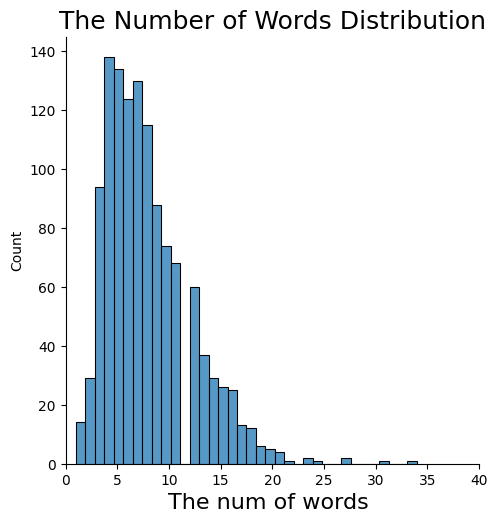

In [27]:
plt.figure(figsize= (8, 8))

sns.displot(df['count'])

plt.xlim(0, 40)

plt.xlabel('The num of words ', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
plt.show()



# Bar plot for each of the new category

In [28]:
category_count = df['category'].value_counts()

categories = category_count.index

categories

Index(['ReserveRestaurant', 'FindRestaurants', 'NONE'], dtype='object', name='category')

In [29]:
category_count

category
ReserveRestaurant    625
FindRestaurants      552
NONE                  56
Name: count, dtype: int64

In [30]:
category_count.index

Index(['ReserveRestaurant', 'FindRestaurants', 'NONE'], dtype='object', name='category')

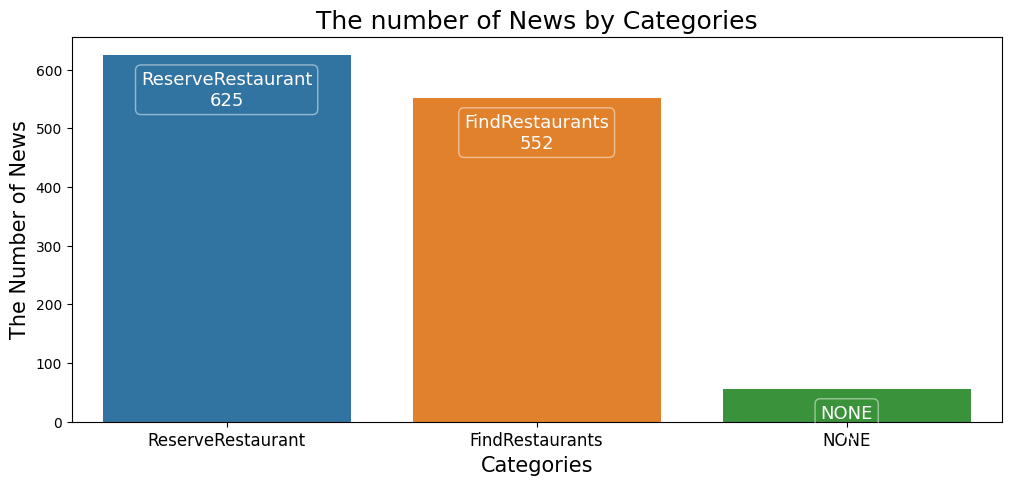

In [31]:
fig = plt.figure(figsize= (12, 5))

ax = fig.add_subplot(111)

sns.barplot(x = category_count.index, y = category_count )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )
    
plt.xlabel('Categories', size = 15)

plt.ylabel('The Number of News', size= 15)

plt.xticks(size = 12)

plt.title("The number of News by Categories" , size = 18)

plt.show()

In [32]:
df['category'].unique()

array(['FindRestaurants', 'ReserveRestaurant', 'NONE'], dtype=object)

In [33]:
df['encoded_text'] = df['category'].astype('category').cat.codes

df.head(10)
#{"FindRestaurant" : 0, "NONE" : 1, "ReserveRestaurant" : 2}

,category,text,count,encoded_text
0,FindRestaurants,I am feeling hungry so I would like to find a ...,14,0
1,FindRestaurants,I would like for it to be in San Jose.,10,0
2,FindRestaurants,I usually like eating the American type of food.,9,0
3,FindRestaurants,Can you give me the address of this restaurant.,9,0
4,FindRestaurants,Can you give me the phone number that I can co...,13,0
5,FindRestaurants,Is there some other restaurant which you can s...,9,0
6,FindRestaurants,Do you have another restaurant matching my nee...,21,0
7,ReserveRestaurant,"Alright, that seems good. I would like to make...",14,2
8,ReserveRestaurant,I will be eating there at 11:30 am so make it ...,13,2
9,ReserveRestaurant,That suits me well. Can you tell me if they fe...,13,2


In [34]:
data_texts = df['text'].to_list()

data_labels = df['encoded_text'].to_list()

# Train Test SPlit

In [35]:
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size = 0.2, random_state = 0 )


train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size = 0.01, random_state = 0 )



# Model Definition

In [36]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation = True, padding = True  )

val_encodings = tokenizer(val_texts, truncation = True, padding = True )

In [37]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))


val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

2023-06-03 17:12:42.450303: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/lib64
2023-06-03 17:12:42.450337: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-03 17:12:42.450362: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (galactica): /proc/driver/nvidia/version does not exist
2023-06-03 17:12:42.450821: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Fine-tuning with the TFTrainer class

In [43]:
num_labels = len(df['category'].unique())

In [44]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [45]:
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments


training_args = TFTrainingArguments(
    output_dir='./results',          
    num_train_epochs=7,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=64,   
    warmup_steps=500,                
    weight_decay=1e-5,               
    logging_dir='./logs',            
    eval_steps=100                   
)

with training_args.strategy.scope():
    trainer_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = num_labels )


trainer = TFTrainer(
    model=trainer_model,                 
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=val_dataset,            
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [46]:
trainer.train()

2023-06-03 17:15:54.829903: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_3"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
input: "Placeholder/_2"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
      type: DT_INT32
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 976
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 37
        }
      }
      shape {
        dim {
          size: 37
        }
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  typ

In [47]:
trainer.evaluate()

2023-06-03 17:23:34.494724: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_3"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
input: "Placeholder/_2"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
      type: DT_INT32
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 247
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:1"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 29
        }
      }
      shape {
        dim {
          size: 29
        }
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  typ

{'eval_loss': 0.2599186897277832}

# Saving & Loading the model

In [49]:
save_directory = "./saved_models" 

model.save_pretrained(save_directory)

tokenizer.save_pretrained(save_directory)

('./saved_models/tokenizer_config.json',
 './saved_models/special_tokens_map.json',
 './saved_models/vocab.txt',
 './saved_models/added_tokens.json')

# Loading Pre-Trained Model

In [50]:
tokenizer_fine_tuned = DistilBertTokenizer.from_pretrained(save_directory)

model_fine_tuned = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

Some layers from the model checkpoint at ./saved_models were not used when initializing TFDistilBertForSequenceClassification: ['dropout_59']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ./saved_models and are newly initialized: ['dropout_99']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [59]:
test_text = test_texts[0]
test_label = test_labels[0]
print(test_label, test_text)

2 Sorry, could you change the booking to 18:30 for 3 people?


In [67]:
hit = 0
miss = 0
for test_text, test_label in zip(train_texts, train_labels):
    predict_input = tokenizer_fine_tuned.encode(
        test_text,
        truncation = True,
        padding = True,
        return_tensors = 'tf'    
    )

    output = model_fine_tuned(predict_input)[0]

    prediction_value = tf.argmax(output, axis = 1).numpy()[0]

    if prediction_value == test_label:
        hit += 1
    else:
        #print(prediction_value, test_label, test_text)
        miss += 1
        
accuracy = hit / (hit + miss)
print(accuracy)
#{"FindRestaurant" : 0, "NONE" : 1, "ReserveRestaurant" : 2}

2 0 That sounds good.
2 0 I'm searching for a place to dine at.
2 0 Yes that is fine.
2 0 I would love to eat some African food.
1 2 Thanks so much!
2 0 Is there anything else? I want to go somewhere close to Pleasant Hill.
2 0 Can you find me somewhere to eat in Dublin?
2 0 Can you give me their address?
2 0 Could you suggest any other restaurant?
2 0 I'm looking for a restaurant to go to. I'd prefer a place that specializes in fish.
0 2 Reserve the table for the 2nd of this month at 17:15.
1 2 No make it at 19:30 and make the reservation for five poeple.
2 0 Can you look for another place to eat in Santa Clara?
2 1 Nope. That's all.
2 0 I think I'm craving Mexican food.
1 2 Thanks, thats all I want
2 0 I want some ramen, I'm really craving it. Can you find me an afforadable place in Morgan Hill?
1 0 Campbell please, thanks.
1 2 Try again to book a table for 2
2 0 I'd like another suggestion please.
2 0 Do they have any liquor supply?
2 0 Barbecue is the best.
2 0 Do they have live mu

KeyboardInterrupt: 

In [63]:
len(test_texts)

10

# Inferencing with Pytorch

In [53]:
import torch

from transformers import DistilBertForSequenceClassification

tokenizer_fine_tuned_pt = DistilBertTokenizer.from_pretrained(save_directory)


model_fine_tuned_pt = DistilBertForSequenceClassification.from_pretrained(save_directory, from_tf = True )


All TF 2.0 model weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.
